# Multiclass logistic regression

https://gluon.mxnet.io/chapter02_supervised-learning/softmax-regression-scratch.html

In [1]:
import gzip
import array
import struct
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def read_int32(fin):
    buf = fin.read(4)
    return struct.unpack('>i', buf)[0]

def read_byte(fin):
    buf = fin.read(1)
    return struct.unpack('B', buf)[0]

def read_images(fin):
    magic = read_int32(fin)
    assert magic == 0x00000803, "magic number != 0x%08x" % magic
    num_images = read_int32(fin)
    num_rows = read_int32(fin)
    num_cols = read_int32(fin)
    data = array.array('B')
    data.fromfile(fin, num_images * num_rows * num_cols)
    return np.array(data).reshape((num_images, num_rows, num_cols))

def read_labels(fin):
    magic = read_int32(fin)
    assert magic == 0x00000801, "magic number != 0x%08x" % magic
    num_labels = read_int32(fin)
    data = array.array('B')
    data.fromfile(fin, num_labels)
    return np.array(data)

In [3]:
with gzip.open('data/3/train-images-idx3-ubyte.gz') as fin:
    train_images = read_images(fin)

with gzip.open('data/3/train-labels-idx1-ubyte.gz') as fin:
    train_labels = read_labels(fin)

with gzip.open('data/3/t10k-images-idx3-ubyte.gz') as fin:
    test_images = read_images(fin)

with gzip.open('data/3/t10k-labels-idx1-ubyte.gz') as fin:
    test_labels = read_labels(fin)

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
def show_image(img, title=""):
    img = np.tile(img[:, :, np.newaxis], (1, 1, 3))
    plt.figure()
    plt.title(title)
    return plt.imshow(img,)

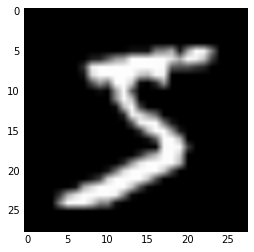

In [5]:
show_image(train_images[0])

In [6]:
train_labels[0]

5

In [7]:
num_examples, num_rows, num_cols = train_images.shape
num_tests, _, _ = test_images.shape
num_inputs = num_rows * num_cols
num_outputs = 10

In [8]:
train_inputs = train_images.reshape(num_examples, num_inputs) / 255
test_inputs = test_images.reshape(num_tests, num_inputs) / 255

In [9]:
train_inputs.shape, train_inputs.shape

((60000, 784), (60000, 784))

In [10]:
from common import transform_to_one_hot

In [11]:
train_outputs = transform_to_one_hot(train_labels, num_outputs)
test_outputs = transform_to_one_hot(test_labels, num_outputs)

In [12]:
train_outputs.shape, test_outputs.shape

((60000, 10), (10000, 10))

In [13]:
from common import split_data
batch_size = 64
train_data = split_data(train_inputs, train_outputs, batch_size)
test_data = split_data(test_inputs, test_outputs, batch_size)

$$softmax(z) = \frac{\exp(z)}{\sum_{i = 1}^{k} \exp(z_i)}$$
$$\hat{y} = softmax(xW + b)$$
$$\min_{W, b} - \sum_{j} {y_j \cdot \log{(\hat{y}_j + 10^{-6})}}$$

In [14]:
# yhat, y: (num_examples, num_outputs)
# return: (num_examples,)
def cross_entropy(yhat, y):
    return - np.sum(y * np.log(yhat+1e-6))

In [15]:
# yhat, y: (num_examples, num_outputs)
# return: (num_examples, num_outputs)
def grad_cross_entropy(yhat, y):
    # D(y * log(yhat + 1e-6)) / dyhat
    # = y / (yhat + 1e-6)
    return - y / (yhat + 1e-6)

In [16]:
# W: (num_inputs, num_outputs)
# b: (num_outputs,)
# x: (num_examples, num_inputs)
# return: (num_examples, num_outputs)
def linear_transform(W, b, x):
    return np.dot(x, W) + b

In [17]:
# z: (num_examples, num_outputs)
# return: (num_examples, num_outputs)
def softmax(z):
    z_min = np.min(z, axis=1)
    z = z - z_min[:, np.newaxis]
    exp = np.exp(z)
    sum_exp = np.sum(exp, axis=1)[:, np.newaxis]
    return exp / sum_exp

In [18]:
# z: (num_examples, num_outputs)
# return: (num_examples, num_outputs, num_outputs)
def grad_softmax(z):
    # diag
    # D(softmax) / dz_i
    # = D(exp(z_i) * sum(exp(z))^-1) / dz_i
    # = D(exp(z_i)) / dz * sum(exp(z))^-1 + exp(z_i) * D(sum(exp(z))^-1) / dz_i
    # = exp(z_i) * sum(exp(z))^-1 + exp(z_i) * -1 * sum(exp(z))^-2 * exp(z_i)
    # = exp(z_i) / sum(exp(z)) - exp(z_i)^2 / sum(exp(z))^2
    
    # off diag
    # D(softmax) / dz_j
    # = D(exp(z_i) * sum(exp(z))^-1) / dz_j
    # = exp(z_i) * D(sum(exp(z))^-1) / dz_j)
    # = exp(z_i) * -1 * sum(exp(z))^-2 * exp(z_j)
    # = - exp(z_i) * exp(z_j) / sum(exp(z))^2
    
    z_min = np.min(z, axis=1)
    z = z - z_min[:, np.newaxis]
    exp = np.exp(z)
    sum_exp = np.sum(exp, axis=1)
    outer_mat = - np.einsum("ij,ik->ijk", exp, exp)
    outer_mat /= sum_exp[:, np.newaxis, np.newaxis]**2
    diag = exp / sum_exp[:, np.newaxis]
    diag_idx = np.arange(diag.shape[1])
    outer_mat[:, diag_idx, diag_idx] += diag
    return outer_mat

In [19]:
# W: (num_outputs, num_inputs)
# b: (num_outputs,)
# x: (num_examples, num_inputs)
# return grad_W: (num_examples, num_outputs, num_inputs)
# return grad_b: (num_examples, num_outputs, num_inputs)
def grad_linear_transform(W, b, x):
    num_examples = x.shape[0]
    num_outputs, num_inputs = W.shape
    grad_W = np.tile(x[:, np.newaxis, :], (1, num_outputs, 1))
    grad_b = np.tile(np.ones((num_outputs, num_inputs)), (num_examples, 1, 1))
    return grad_W, grad_b

In [20]:
def gradient(W, b, x, y):
    z = linear_transform(W, b, x)
#     print("z", z)
    yhat = softmax(z)
#     print("yhat", yhat)
    dCE = grad_cross_entropy(yhat, y)
#     print("dCE", dCE)
    dSM = grad_softmax(z)
#     print("dSM", dSM)
    dCE_dz = np.einsum("ik,ikj->ij", dCE, dSM)
#     print(dCE.shape, dSM.shape, dCE_dz.shape)
    grad_dW = np.einsum("ij,ik->ijk", x, dCE_dz)
#     print("grad_dW", grad_dW)
    grad_db = dCE_dz
#     print("grad_db", grad_db)
    sum_grad_dW = np.sum(grad_dW, axis=0)
    sum_grad_db = np.sum(grad_db, axis=0)
    return sum_grad_dW, sum_grad_db

In [21]:
def rand_prob_dist(example_count, choice_count):
    yhat = np.random.uniform(size=(example_count, choice_count))
    yhat = yhat / np.sum(yhat, axis=1)[:, np.newaxis]
    return yhat

def rand_one_hot(example_count, choice_count):
    r = np.random.uniform(size=(example_count, choice_count))
    a = np.argmax(r, axis=1)
    y = np.zeros((example_count, num_outputs))
    y[np.arange(a.size), a] = 1
    return y

In [22]:
def calc_numeric_grad(func, x, delta=1e-3):
    y = func(x)
    input_size = 1 if np.isscalar(x) else x.size
    output_size = 1 if np.isscalar(y) else y.size
    delta_mat = np.identity(input_size) * delta
    grad = np.zeros((output_size, input_size))
    for i in range(input_size):
        h = delta_mat[i]
        y_ = func(x + h)
        g = (y_ - y) / delta
        grad[:, i] = g
    return grad

In [23]:
def test_grad_cross_entropy(delta=1e-4):
    yhat = rand_prob_dist(1, num_outputs)
#     y = rand_one_hot(1, num_outputs)
    y = np.ones(num_outputs)
    grad1 = calc_numeric_grad(lambda x: cross_entropy(x, y), yhat)
    grad2 = grad_cross_entropy(yhat, y)
    print("numeric", grad1)
    print("grad", grad2)
    print("diff", grad1 - grad2)

test_grad_cross_entropy()

numeric [[ -6.64871383 -13.79008575  -7.86607837  -5.75543554 -13.87938532
  -15.89239405  -5.0912597  -29.52864823 -18.11170707 -16.46491101]]
grad [[ -6.67086559 -13.88560756  -7.89709725  -5.77202988 -13.97615115
  -16.0193498   -5.10424218 -29.96894184 -18.27671874 -16.60120465]]
diff [[ 0.02215176  0.09552181  0.03101887  0.01659434  0.09676583  0.12695575
   0.01298249  0.44029361  0.16501168  0.13629364]]


In [24]:
def test_grad_softmax(delta=1e-3):
    z = np.random.randn(2, 3)
    h = rand_one_hot(1, num_outputs) * delta
    grad1 = np.array([calc_numeric_grad(softmax, r[np.newaxis, :]) for r in z])
    grad2 = grad_softmax(z)
    print("numeric", grad1)
    print("grad", grad2)
    print("diff", grad1 - grad2)

test_grad_softmax()

numeric [[[ 0.16463162 -0.05303971 -0.11155265]
  [-0.05304223  0.19014713 -0.13706879]
  [-0.1115894  -0.13710742  0.24862145]]

 [[ 0.2495069  -0.18536064 -0.06420285]
  [-0.18532967  0.22900543 -0.04365492]
  [-0.06417723 -0.04364478  0.10785777]]]
grad [[[ 0.16458352 -0.05302673 -0.11155679]
  [-0.05302673  0.1901006  -0.13707387]
  [-0.11155679 -0.13707387  0.24863067]]

 [[ 0.24951243 -0.18533378 -0.06417865]
  [-0.18533378  0.22897224 -0.04363846]
  [-0.06417865 -0.04363846  0.10781711]]]
diff [[[  4.81016796e-05  -1.29767051e-05   4.13724692e-06]
  [ -1.54977531e-05   4.65214333e-05   5.08358523e-06]
  [ -3.26039267e-05  -3.35447282e-05  -9.22083226e-06]]

 [[ -5.53015043e-06  -2.68636109e-05  -2.42037136e-05]
  [  4.10770596e-06   3.31888828e-05  -1.64573854e-05]
  [  1.42244451e-06  -6.32527203e-06   4.06610992e-05]]]


In [25]:
def sgd_update(W, b, x, y, rate):
    grad_W, grad_b = gradient(W, b, x, y)
#     print("grad_W", grad_W)
#     print("grad_b", grad_b)
    W[:] = W - rate * grad_W
    b[:] = b - rate * grad_b
    return W, b

In [26]:
epochs = 10
learning_rate = .002

W = np.random.randn(num_inputs, num_outputs)
b = np.random.randn(num_outputs)

In [27]:
for e in range(epochs):
    cumulative_cross_entroy = 0
    for bx, by in train_data:
#         print(W.shape)
#         print(W)
#         print(b.shape)
#         print(b)
        z = linear_transform(W, b, bx)
        yhat = softmax(z)
        loss = cross_entropy(yhat, by)
        cumulative_cross_entroy += loss
        sgd_update(W, b, bx, by, learning_rate)
#         print(W.shape)
#         print("W", W)
#         print(np.max(W))
#         print(b.shape)
#         print("b", b)
#         print(loss.shape)
#         print(loss)
    print(cumulative_cross_entroy)

134103.13404
46948.8053428
38332.3570756
34101.5477359
31406.1739544
29477.9436192
28005.7568991
26831.8976052
25866.5589102
25054.1887488


In [28]:
def model_predict(W, b, x):
    z = linear_transform(W, b, x)
    yhat = softmax(z)
    pred = np.argmax(yhat, axis=1)
    return pred

In [29]:
num_correct = 0.0
num_total = len(test_inputs)
for tx, ty in test_data:
    pred = model_predict(W, b, tx)
    label = np.argmax(ty, axis=1)
    num_correct += np.sum(pred == label)
print(num_correct / num_total)

0.8991


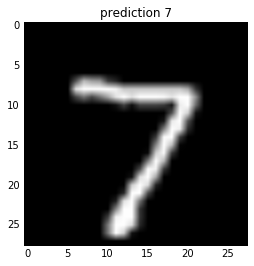

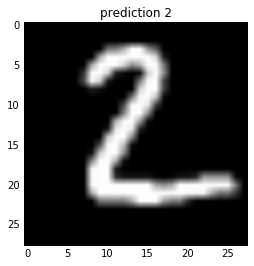

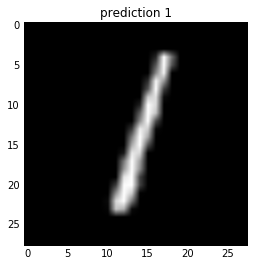

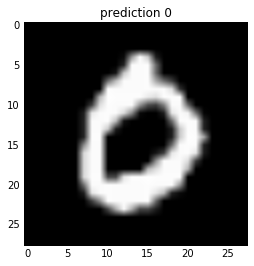

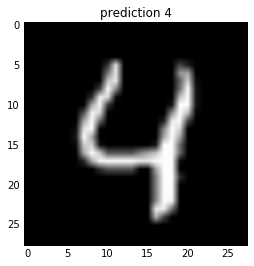

In [31]:
for i in range(5):
    pred = model_predict(W, b, test_inputs[np.newaxis, i])
    show_image(test_images[i], "prediction %d" % pred)